In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from scipy.stats import mannwhitneyu
import numpy as np

## Load and process data

I load the data from the assignment 2. 

In [2]:
# Load data
df_clinical = pd.read_csv('_data/clinical_and_registery.csv').set_index('pnr')
df_clinical['year'] = df_clinical['start'].apply(lambda x: int(x[:4]))

In [3]:
df_clinical

,start,crp,pain,tjc,sjc,drug,fu_trt,stopped_trt,nb_any_inpatient_visit,nb_i_inpatient_visit,nb_i_outpatient_visit,year
pnr,,,,,,,,,,,,
6,2012-10-31,NaN,NaN,NaN,NaN,A,3.900000,1,1.0,0.0,0.0,2012
142,2014-09-01,18.0,0.0,1.0,3.0,A,41.600000,0,0.0,0.0,0.0,2014
2961,2010-11-19,1.0,1.0,1.0,1.0,A,60.000000,0,0.0,0.0,0.0,2010
6368,2012-12-13,7.0,13.0,8.0,8.0,A,60.000000,0,1.0,0.0,0.0,2012
6857,2013-04-08,11.0,15.0,8.0,7.0,A,58.633333,0,2.0,0.0,0.0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
2118501,2013-05-30,0.9,31.0,6.0,10.0,B,22.466667,1,5.0,0.0,0.0,2013
2120670,2013-07-02,NaN,NaN,NaN,NaN,B,55.800000,0,0.0,0.0,0.0,2013
2129788,2011-04-20,6.0,26.0,1.0,1.0,B,60.000000,0,0.0,0.0,0.0,2011


As the incidence seems to vary in the first assigments, I extracted the year of treatment start to be able to correct for it later. I also kept the variables created in the second assigment for correction. 

I just checks that the different included variables were not too correlated, and thus describing different aspects of the disease. 

In [4]:
display(df_clinical[['crp', 'pain', 'tjc', 'sjc',
       'nb_any_inpatient_visit', 'nb_i_inpatient_visit',
       'nb_i_outpatient_visit', 'year']].corr().round(2))

,crp,pain,tjc,sjc,nb_any_inpatient_visit,nb_i_inpatient_visit,nb_i_outpatient_visit,year
crp,1.00,0.21,0.07,0.25,0.10,0.01,0.03,-0.07
pain,0.21,1.00,0.30,0.20,0.06,-0.00,0.02,0.01
tjc,0.07,0.30,1.00,0.48,-0.05,0.00,0.02,-0.03
sjc,0.25,0.20,0.48,1.00,-0.08,0.03,0.01,-0.12
nb_any_inpatient_visit,0.10,0.06,-0.05,-0.08,1.00,0.19,0.07,-0.05
nb_i_inpatient_visit,0.01,-0.00,0.00,0.03,0.19,1.00,0.34,0.03
nb_i_outpatient_visit,0.03,0.02,0.02,0.01,0.07,0.34,1.00,0.04
year,-0.07,0.01,-0.03,-0.12,-0.05,0.03,0.04,1.00


In the analysis of the first assignements, we have seen that there were missing data. There are different ways of handling missing data in terms of imputation or modelling. Here I decided to use a model that require data imputation or exclusion of patients with missing data. In an ideal world some discussion with clinicians can help understand if the data are missing at random or not. What I did to check the assumption of missing at random was to compare the distribution between patient with no missing data and patient with at least one missing data. Note that this analysis could be improved but was choosen for the sake of simplicity. I used a Mann Whitney U test to compare the distributions.

In [5]:
df_clinical["nb_missing"] = df_clinical.isna().sum(axis = 1)
dict_res = {}
# For ordial data
for col in ['crp', 'pain', 'tjc', 'sjc','fu_trt', 'nb_any_inpatient_visit', 'nb_i_inpatient_visit',
       'nb_i_outpatient_visit', "year", 'stopped_trt']:
    u, p_value = mannwhitneyu(df_clinical[df_clinical["nb_missing"]==0][col], 
                              df_clinical[df_clinical["nb_missing"]>0][col].dropna())
    u = u/(len(df_clinical[df_clinical["nb_missing"]==0][col])*len(df_clinical[df_clinical["nb_missing"]>0][col].dropna()))
    dict_res[col] = (round(u, 2), round(p_value, 3))

pd.DataFrame(dict_res, index = ['AUC', "p-value"]).T

,AUC,p-value
crp,0.50,0.958
pain,0.46,0.483
tjc,0.49,0.830
sjc,0.52,0.613
fu_trt,0.52,0.297
nb_any_inpatient_visit,0.50,0.848
nb_i_inpatient_visit,0.50,0.708
nb_i_outpatient_visit,0.50,0.702
year,0.44,0.002
stopped_trt,0.50,0.989


What we see here is that missing values are dependent of the year of inclusion, hopefully this is not the main variable of interest of our study. I will assume here that the inclusion criteria did not change over the years and impute missing data with the mean to try not to loose to much power. 

# Analyse method 

### Separated analysis for treatments:

First, the two treatment might have different impact on the stopping date. Thus instead of including all the interactions with the other variables, I rather separate the analysis for the two treatments, even if it can reduce power. 

### Correction:

Then we are interested in the effect of drug, CRP, pain, TJC and SJC, yet to make sure there effect is not related to an other cofounding, I also correct for the different variables studied in the other assigments: the tree variable linked to the registeries events and the year of treatment start. Note that to limit the dicrease of power I did not includ interaction between and with correction variables. 

### Model choice:

I used a Cox Proportional Hazard model and check if the value of the proportional hazard was significantly different from 1. Note that I checked the assumptions of the proportionnal hazard using scaled Schoenfeld residuals computed by the [package](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html). 


In [6]:
correction = "+ nb_any_inpatient_visit + nb_i_inpatient_visit + nb_i_outpatient_visit + year"
features = ['crp', 'pain', 'tjc', 'sjc']

## Treatment A

In [7]:
df_a = df_clinical[df_clinical['drug'] == 'A']
df_a.loc[:, features] = df_a[features].fillna(df_a[features].mean())

In [8]:
cph = CoxPHFitter()
cph.fit(df_a, duration_col='fu_trt', event_col='stopped_trt', 
                formula="crp + pain + tjc + sjc + crp * pain + crp * tjc + crp * sjc + pain * tjc + pain * sjc + tjc * sjc " + correction)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 687 total observations, 323 right-censored observations>
             duration col = 'fu_trt'
                event col = 'stopped_trt'
      baseline estimation = breslow
   number of observations = 687
number of events observed = 364
   partial log-likelihood = -2214.90
         time fit was run = 2025-04-14 12:13:24 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
crp                     0.01      1.01      0.01           -0.00            0.03                1.00                1.03
pain                    0.01      1.01      0.00            0.00            0.02                1.00                1.02
tjc                    -0.00      1.00      0.04           -0.08            0.07                0.93                1.07
sjc                     0.02      1.02      0.04           -0.07            0.10                0.94                1.11
nb_any_inpatient_visit  0.03      1.03      0.03           -0.02            0.09                0.98                1.09
nb_i_inpatient_visit    0.04      1.04      0.23           -0.41            0.48                0.67                1.61
nb_i_outpatient_visit  -0.68      0.51      0.91           -2.46            1.10                0.09                3.01
year                   -0.03      0.97      0.03           -0.08            0.03                0.92                1.03
crp:pain               -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
crp:tjc                 0.00      1.00      0.00           -0.00            0.00                1.00                1.00
crp:sjc                 0.00      1.00      0.00           -0.00            0.00                1.00                1.00
pain:tjc                0.00      1.00      0.00           -0.00            0.00                1.00                1.00
pain:sjc               -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
tjc:sjc                -0.00      1.00      0.00           -0.01            0.00                0.99                1.00

                        cmp to     z      p  -log2(p)
covariate                                            
crp                       0.00  1.69   0.09      3.47
pain                      0.00  2.92 <0.005      8.15
tjc                       0.00 -0.11   0.91      0.14
sjc                       0.00  0.42   0.67      0.57
nb_any_inpatient_visit    0.00  1.13   0.26      1.94
nb_i_inpatient_visit      0.00  0.16   0.87      0.20
nb_i_outpatient_visit     0.00 -0.75   0.45      1.14
year                      0.00 -1.04   0.30      1.74
crp:pain                  0.00 -2.17   0.03      5.07
crp:tjc                   0.00  0.51   0.61      0.72
crp:sjc                   0.00  1.05   0.29      1.77
pain:tjc                  0.00  0.27   0.79      0.35
pain:sjc                  0.00 -0.07   0.95      0.08
tjc:sjc                   0.00 -1.12   0.26      1.93
---
Concordance = 0.58
Partial AIC = 4457.81
log-likelihood ratio test = 32.15 on 14 df
-log2(p) of ll-ratio test = 8.03

In [9]:
np.exp(cph.confidence_intervals_)

,95% lower-bound,95% upper-bound
covariate,,
crp,0.997903,1.029251
pain,1.004480,1.023004
tjc,0.927400,1.069479
sjc,0.936995,1.105800
nb_any_inpatient_visit,0.976071,1.093709
nb_i_inpatient_visit,0.666340,1.612504
nb_i_outpatient_visit,0.085338,3.005834
year,0.919910,1.026050
crp:pain,0.999529,0.999976


Some associations were found even if the coefficients are really close to 1: 
- pain: [1.004458,	1.022991] (p-value < 0.005) accelerate the treatment stop,
- crp:pain: [0.999528,	0.999975] (p-value: 0.03) slow the treatment stop.

I just checked the assumption on proportionnal hazard. Note that here I plot all the different indicators, as there was an issue with the years, but I did not for the other analysis as it takes quite a bit of space.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See lin

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 687 total observations, 323 right-censored observations>
         test_name = proportional_hazard_test

---
                             test_statistic    p  -log2(p)
crp                    km              1.24 0.26      1.92
                       rank            1.17 0.28      1.84
crp:pain               km              1.39 0.24      2.07
                       rank            1.37 0.24      2.05
crp:sjc                km              0.18 0.67      0.58
                       rank            0.18 0.67      0.57
crp:tjc                km              0.48 0.49      1.04
                       rank            0.51 0.48      1.07
nb_any_inpatient_visit km              1.43 0.23      2.11
                       rank            1.44 0.23      2.12
nb_i_inpatient_visit   km              1.22 0.27      1.89
                       rank            1.19 0.27      1.87
nb_i_outpatient_visit  km              1.32 0.25      2.00
                       rank            1.38 0.24      2.05
pain                   km              3.21 0.07      3.78
                       rank            3.19 0.07      3.75
pain:sjc               km              0.05 0.82      0.29
                       rank            0.04 0.83      0.26
pain:tjc               km              0.63 0.43      1.23
                       rank            0.62 0.43      1.21
sjc                    km              0.15 0.70      0.52
                       rank            0.13 0.71      0.48
tjc                    km              0.13 0.72      0.47
                       rank            0.11 0.74      0.44
tjc:sjc                km              0.34 0.56      0.83
                       rank            0.37 0.55      0.87
year                   km              5.18 0.02      5.45
                       rank            5.19 0.02      5.46



1. Variable 'year' failed the non-proportional test: p-value is 0.0227.

   Advice 1: the functional form of the variable 'year' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'year' using pd.cut, and then specify it in `strata=['year',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/l

[[<Axes: xlabel='rank-transformed time\n(p=0.2798)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2649)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0742)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0730)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7352)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7222)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7148)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6961)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2294)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2315)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2744)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2696)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2408)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2501)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0227)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0229)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2414)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2386)'>],
 [<Axes: xlabel='rank-transformed tim

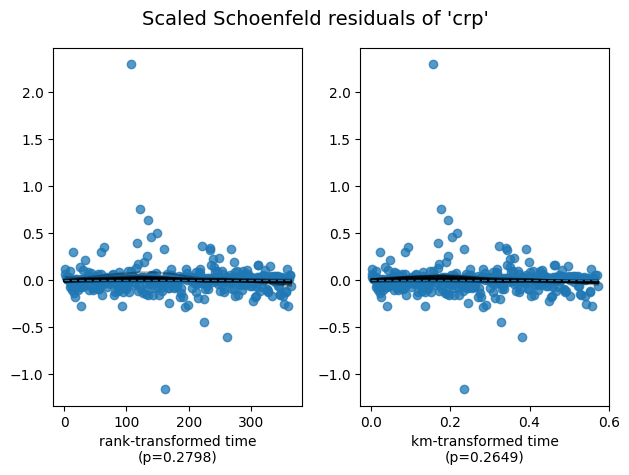

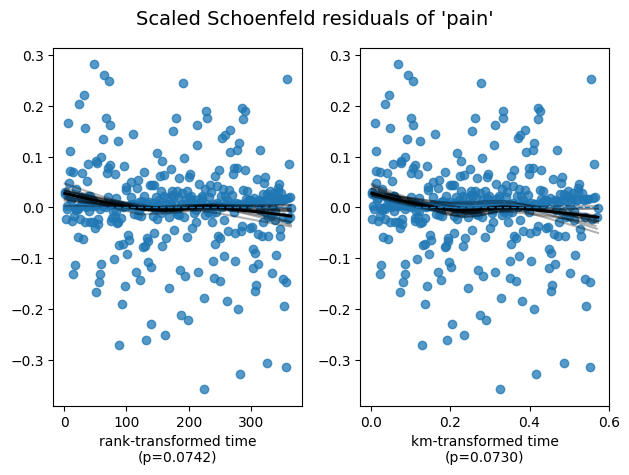

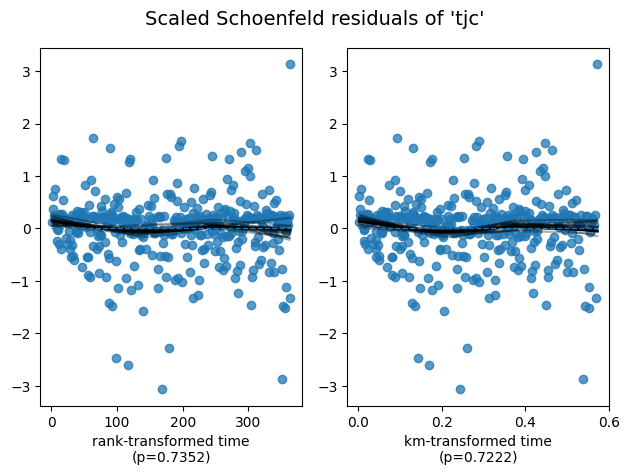

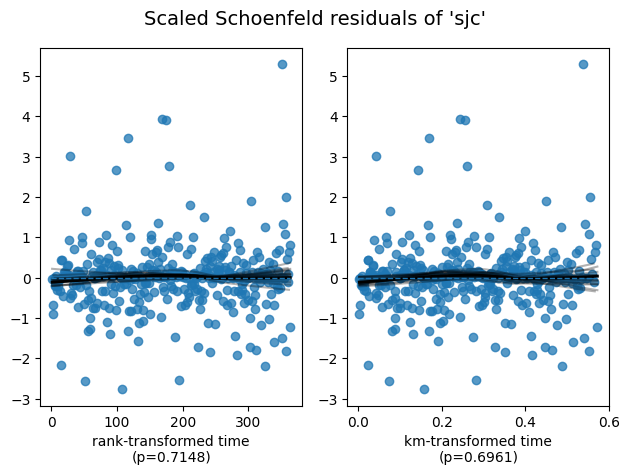

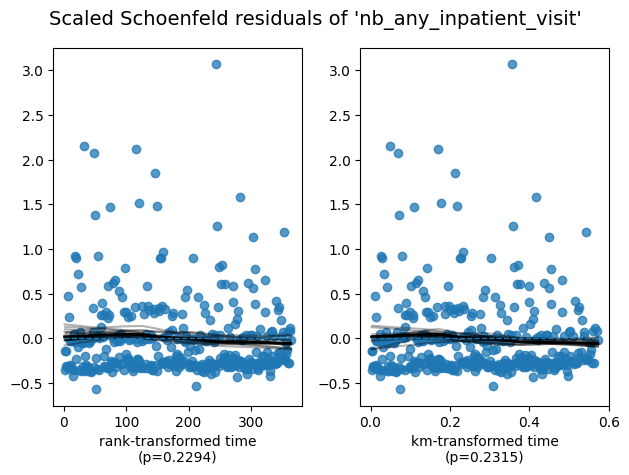

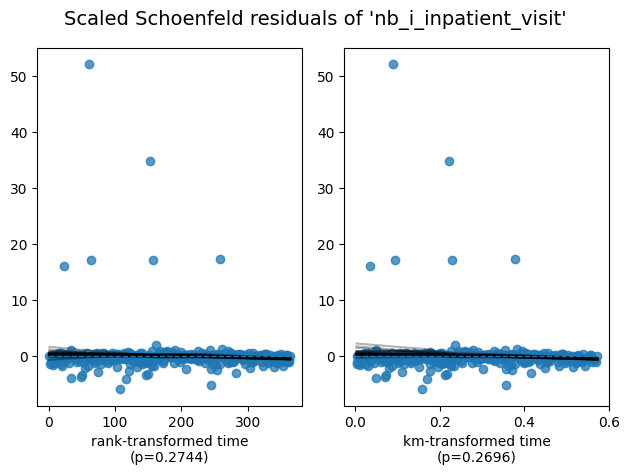

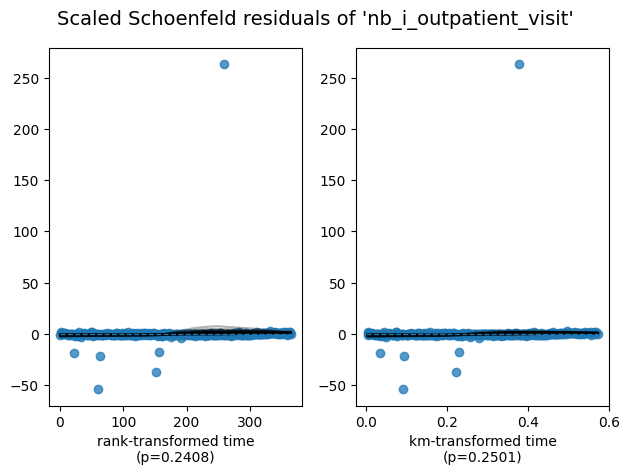

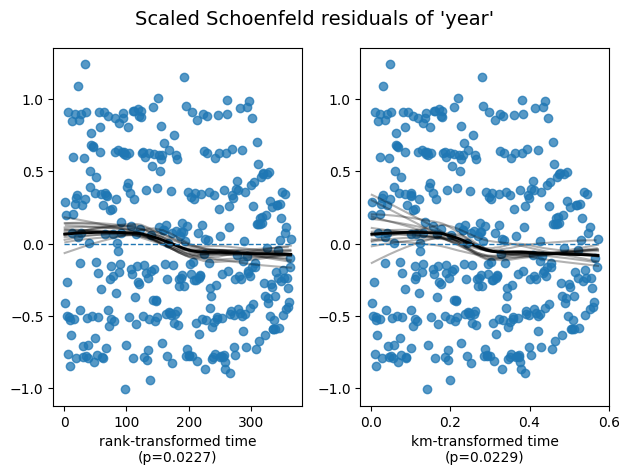

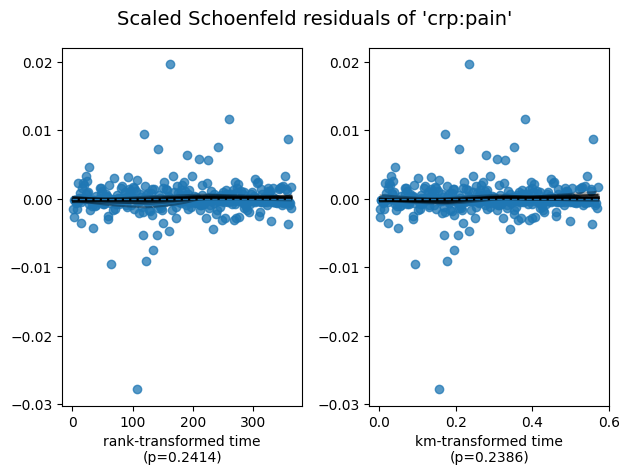

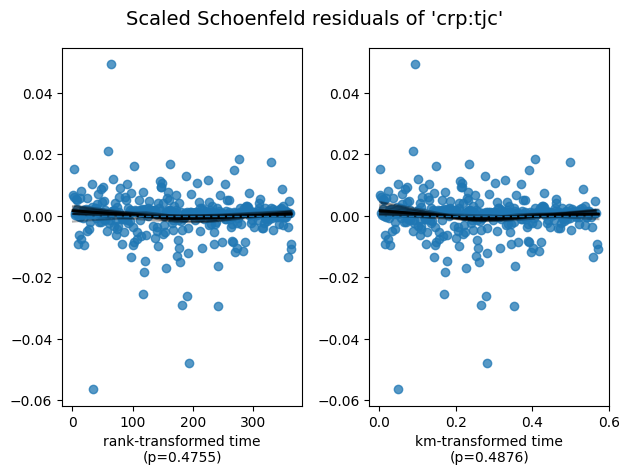

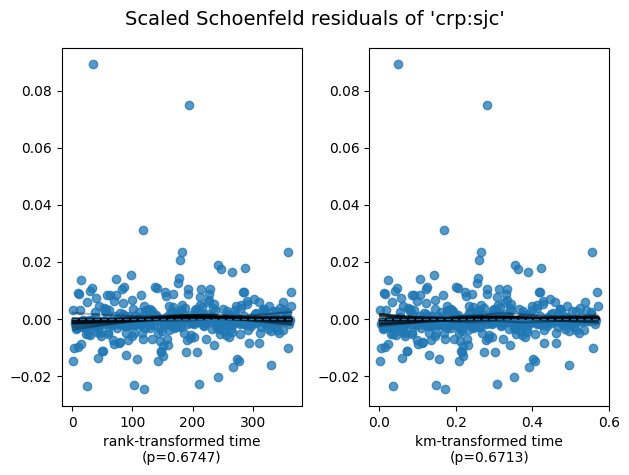

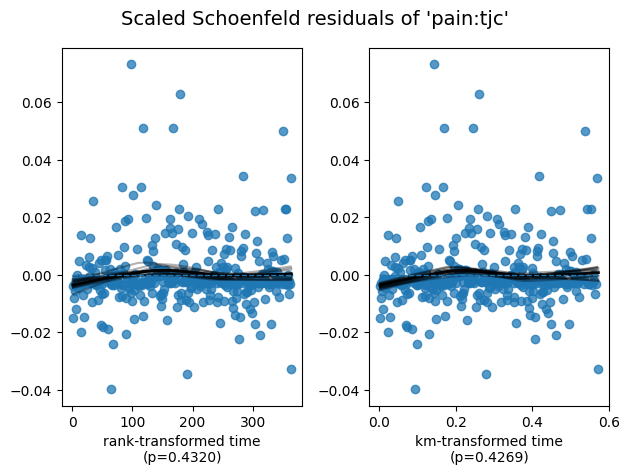

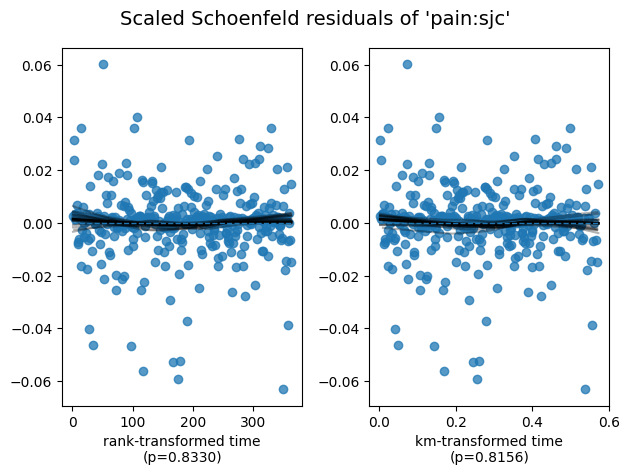

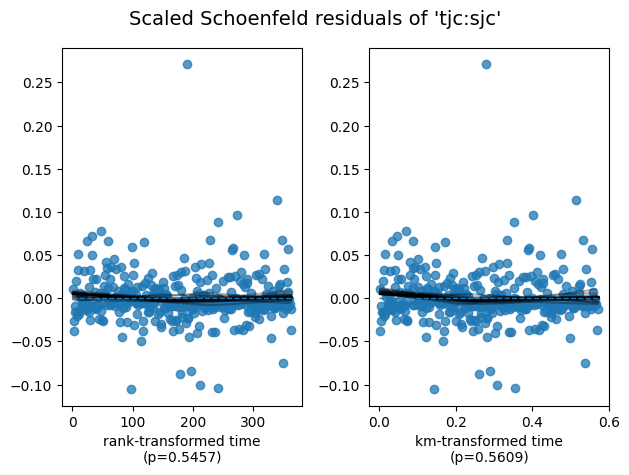

In [10]:
cph.check_assumptions(df_a, p_value_threshold=0.05, show_plots=True)

## Treatment B

In [11]:
df_b = df_clinical[df_clinical['drug'] == 'B']
df_b.loc[:, features] = df_b[features].fillna(df_b[features].mean())


In [12]:
cph = CoxPHFitter()
cph.fit(df_b, duration_col='fu_trt', event_col='stopped_trt', 
                formula="crp + pain + tjc + sjc + crp * pain + crp * tjc + crp * sjc + pain * tjc + pain * sjc + tjc * sjc " + correction)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 498 total observations, 321 right-censored observations>
             duration col = 'fu_trt'
                event col = 'stopped_trt'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 177
   partial log-likelihood = -1029.97
         time fit was run = 2025-04-14 12:13:32 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
crp                    -0.00      1.00      0.01           -0.03            0.02                0.97                1.03
pain                    0.00      1.00      0.01           -0.01            0.02                0.99                1.02
tjc                     0.03      1.03      0.05           -0.06            0.13                0.94                1.14
sjc                    -0.04      0.96      0.06           -0.16            0.08                0.86                1.09
nb_any_inpatient_visit -0.01      0.99      0.03           -0.06            0.04                0.94                1.04
nb_i_inpatient_visit    0.25      1.28      0.29           -0.33            0.82                0.72                2.28
nb_i_outpatient_visit  -0.59      0.56      1.07           -2.68            1.51                0.07                4.51
year                    0.03      1.03      0.04           -0.06            0.11                0.95                1.12
crp:pain               -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
crp:tjc                 0.00      1.00      0.00           -0.00            0.00                1.00                1.00
crp:sjc                -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
pain:tjc               -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
pain:sjc                0.00      1.00      0.00           -0.00            0.00                1.00                1.00
tjc:sjc                -0.00      1.00      0.00           -0.01            0.00                0.99                1.00

                        cmp to     z    p  -log2(p)
covariate                                          
crp                       0.00 -0.08 0.94      0.09
pain                      0.00  0.60 0.55      0.87
tjc                       0.00  0.72 0.47      1.08
sjc                       0.00 -0.60 0.55      0.87
nb_any_inpatient_visit    0.00 -0.37 0.71      0.49
nb_i_inpatient_visit      0.00  0.85 0.40      1.33
nb_i_outpatient_visit     0.00 -0.55 0.58      0.78
year                      0.00  0.67 0.51      0.98
crp:pain                  0.00 -0.01 0.99      0.01
crp:tjc                   0.00  1.24 0.22      2.21
crp:sjc                   0.00 -0.56 0.58      0.80
pain:tjc                  0.00 -0.54 0.59      0.77
pain:sjc                  0.00  0.69 0.49      1.03
tjc:sjc                   0.00 -0.67 0.50      1.00
---
Concordance = 0.55
Partial AIC = 2087.94
log-likelihood ratio test = 8.85 on 14 df
-log2(p) of ll-ratio test = 0.25

In [13]:
cph.check_assumptions(df_b, p_value_threshold=0.05, show_plots=False)

Proportional hazard assumption looks okay.


[]

No significant results, test without interaction, so I test without interactions.

In [14]:
cph = CoxPHFitter()
cph.fit(df_b.dropna(), duration_col='fu_trt', event_col='stopped_trt', 
                formula="crp + pain + tjc + sjc " + correction)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 498 total observations, 321 right-censored observations>
             duration col = 'fu_trt'
                event col = 'stopped_trt'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 177
   partial log-likelihood = -1031.05
         time fit was run = 2025-04-14 12:13:32 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
crp                     0.00      1.00      0.00           -0.00            0.01                1.00                1.01
pain                    0.01      1.01      0.00           -0.00            0.01                1.00                1.01
tjc                     0.02      1.02      0.02           -0.01            0.05                0.99                1.05
sjc                    -0.03      0.98      0.02           -0.07            0.02                0.93                1.02
nb_any_inpatient_visit -0.01      0.99      0.03           -0.07            0.04                0.94                1.04
nb_i_inpatient_visit    0.25      1.28      0.29           -0.33            0.82                0.72                2.28
nb_i_outpatient_visit  -0.57      0.57      1.06           -2.65            1.52                0.07                4.56
year                    0.03      1.03      0.04           -0.05            0.12                0.95                1.12

                        cmp to     z    p  -log2(p)
covariate                                          
crp                       0.00  0.55 0.58      0.79
pain                      0.00  1.46 0.15      2.78
tjc                       0.00  1.15 0.25      1.99
sjc                       0.00 -1.11 0.27      1.92
nb_any_inpatient_visit    0.00 -0.43 0.67      0.59
nb_i_inpatient_visit      0.00  0.84 0.40      1.32
nb_i_outpatient_visit     0.00 -0.53 0.59      0.75
year                      0.00  0.74 0.46      1.12
---
Concordance = 0.56
Partial AIC = 2078.10
log-likelihood ratio test = 6.69 on 8 df
-log2(p) of ll-ratio test = 0.81

In [15]:
cph.check_assumptions(df_b, p_value_threshold=0.05, show_plots=False)

Proportional hazard assumption looks okay.


[]

Nothing significant neither. 

# Conclusion

It seems that that pain and interaction between pain and crp can help predict the treatment A stop. No variable was found associated with the treatment B stop. 